In [1]:
# Install necessary libraries
!pip install diffusers datasets transformers accelerate scipy ftfy

import datasets
import diffusers
import huggingface_hub
import torch
from diffusers import DDPMPipeline
from PIL import Image
from datasets import load_dataset
from torchvision import transforms
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
from torch.nn import functional as F
from matplotlib import pyplot as plt

# Suppress warnings
datasets.logging.set_verbosity_error()
diffusers.logging.set_verbosity_error()
huggingface_hub.logging.set_verbosity_error()

# Load your own dataset
dataset = load_dataset("lucabaggi/animal-wildlife", split="train")


# Create a subset of the first 1024 images
dataset = dataset.select(range(1024))

# Preprocessing
image_size = 64
preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Added slight rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Added color augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
])

def transform(examples):
    examples["pixel_values"] = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return examples

# Apply the transform to the dataset
dataset.set_transform(transform)

# Create a custom dataset class to return tensors directly
class TensorDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset):
        self.hf_dataset = hf_dataset

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        return self.hf_dataset[idx]["pixel_values"]  # Return tensor directly

# Wrap the dataset in the custom class
tensor_dataset = TensorDataset(dataset)

# Create dataloader
batch_size = 8
train_dataloader = torch.utils.data.DataLoader(tensor_dataset, batch_size=batch_size, shuffle=True)

# Model and scheduler
model = UNet2DModel(
    sample_size=image_size,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="scaled_linear"  # Changed beta schedule for better quality
)

# Optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 80 # Adjust as needed

for epoch in range(num_epochs):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch.to("cuda")  # Move batch to GPU
        noise = torch.randn(clean_images.shape).to("cuda")
        timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (batch_size,), device="cuda").long()
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        noise_pred = model(noisy_images, timesteps).sample
        loss = F.mse_loss(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print(f"Epoch {epoch}, Step {step}: Loss = {loss.item()}")

# Save the model
# Replace with your desired path
torch.save(model.state_dict(), "animal_diffusion_model.pth")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

README.md:   0%|          | 0.00/5.03k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/265M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/291M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/140M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/4320 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1080 [00:00<?, ? examples/s]

Epoch 0, Step 0: Loss = 1.1107861995697021
Epoch 0, Step 100: Loss = 0.18488448858261108
Epoch 1, Step 0: Loss = 0.2173788994550705
Epoch 1, Step 100: Loss = 0.04240204021334648
Epoch 2, Step 0: Loss = 0.06382712721824646
Epoch 2, Step 100: Loss = 0.057719886302948
Epoch 3, Step 0: Loss = 0.06447850912809372
Epoch 3, Step 100: Loss = 0.0416349358856678
Epoch 4, Step 0: Loss = 0.030268145725131035
Epoch 4, Step 100: Loss = 0.13942310214042664
Epoch 5, Step 0: Loss = 0.11859103292226791
Epoch 5, Step 100: Loss = 0.06166716665029526
Epoch 6, Step 0: Loss = 0.06833253055810928
Epoch 6, Step 100: Loss = 0.07456780970096588
Epoch 7, Step 0: Loss = 0.0382654145359993
Epoch 7, Step 100: Loss = 0.019632097333669662
Epoch 8, Step 0: Loss = 0.038676824420690536
Epoch 8, Step 100: Loss = 0.05801835656166077
Epoch 9, Step 0: Loss = 0.10639338195323944
Epoch 9, Step 100: Loss = 0.03769353777170181
Epoch 10, Step 0: Loss = 0.033930905163288116
Epoch 10, Step 100: Loss = 0.04172971472144127
Epoch 11, 

Length of the dataset: 1024


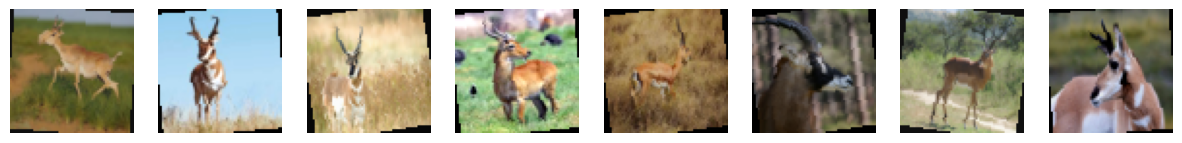

In [2]:
# Check the length of the dataset
print(f"Length of the dataset: {len(dataset)}")

# Visualize some images from the dataset
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    for i in range(num_images):
        # Get an image from the dataset
        image = dataset[i]["pixel_values"]  # Access the preprocessed tensor
        # Convert tensor to numpy and denormalize
        image = image.permute(1, 2, 0).cpu().numpy()  # Change from (C, H, W) to (H, W, C)
        image = (image * 0.5) + 0.5  # Denormalize from [-1, 1] to [0, 1]
        axes[i].imshow(image)
        axes[i].axis("off")
    plt.show()

# Visualize 5 images
visualize_images(dataset, num_images=8)

## Generate images from the trained model

<ipython-input-4-97e89ca4876a>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("animal_diffusion_model.pth"))


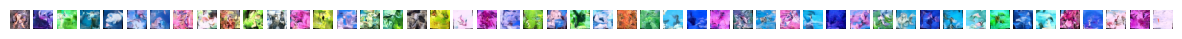

In [4]:
import torch
torch.cuda.empty_cache()
from diffusers import DDPMScheduler
from diffusers import UNet2DModel
import matplotlib.pyplot as plt

# Load the trained model
model = UNet2DModel(
    sample_size=64,  # Match the image size used during training
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(64, 128, 256, 512),  # Number of channels in each block
    down_block_types=(
        "DownBlock2D",     # Downsampling blocks
        "DownBlock2D",
        "AttnDownBlock2D", # Downsampling blocks with attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",   # Upsampling blocks with attention
        "AttnUpBlock2D",
        "UpBlock2D",       # Upsampling blocks
        "UpBlock2D"),
).to("cuda")

# Load the saved model weights
model.load_state_dict(torch.load("animal_diffusion_model.pth"))
model.eval()  # Set the model to evaluation mode

# Set up noise scheduler
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000,
    beta_schedule="scaled_linear"
)

# Function to generate images in batches
def generate_images_batched(num_images, batch_size=4, image_size=64):  # Added batch_size and image_size parameters
    all_generated_images = []
    num_batches = (num_images + batch_size - 1) // batch_size  # Calculate number of batches

    for _ in range(num_batches):
        with torch.no_grad():
            # Start from random noise (adjusted for batch_size and image_size)
            noise = torch.randn((batch_size, 3, image_size, image_size)).to("cuda")
            images = noise

            # Denoising loop
            for t in noise_scheduler.timesteps:
                noise_pred = model(images, t).sample
                images = noise_scheduler.step(noise_pred, t, images).prev_sample

            # Convert images to CPU and denormalize
            images = images.detach().cpu()
            images = (images * 0.5) + 0.5
            images = torch.clamp(images, 0, 1)

        all_generated_images.extend(images)  # Add generated batch to the list

    return all_generated_images[:num_images]  # Return only the desired number of images

# Generate and visualize images
num_images = 50
generated_images = generate_images_batched(num_images, batch_size=4, image_size=64)  # Generate in batches of 10 at 64x64 resolution


# Plot the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")
plt.show()

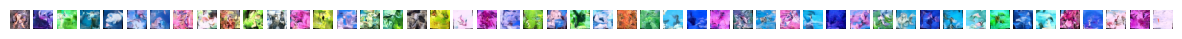

In [5]:
import os
from matplotlib import pyplot as plt

# Create a directory to save the images
os.makedirs("images", exist_ok=True)

# Plot and save the generated images
fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
for i, img in enumerate(generated_images):
    img = img.permute(1, 2, 0)  # Change from (C, H, W) to (H, W, C)
    axes[i].imshow(img)
    axes[i].axis("off")

    # Save each image with a zero-padded two-digit number
    filename = f"images/animal_{i:02d}.png"
    plt.imsave(filename, img.numpy())

# Save the entire grid of images
plt.savefig("images/animal_grid.png")
plt.show()

In [6]:
# !rm -rf images/

# Utility to zip a file
import shutil
shutil.make_archive("animals", "zip", "images")

'/content/animals.zip'